In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

mpl.rc('image', interpolation='nearest', origin='lower', aspect='auto', cmap='bwr')
mpl.rc('axes', grid=False)
mpl.rc('figure', figsize=(10,5))

from sklearn.metrics import hamming_loss, accuracy_score, roc_auc_score

In [2]:
dataset = np.load('data/beatles/ml_dataset/chromagram_block=4096_hop=2048_bins=-48,67_div=1/dataset.npz')

X_train_orig, Y_train_orig, X_valid_orig, Y_valid_orig, X_test_orig, Y_test_orig = \
    dataset['X_train'], dataset['Y_train'], \
    dataset['X_valid'], dataset['Y_valid'], \
    dataset['X_test'], dataset['Y_test']

feature_count = X_train_orig.shape[1]
target_count = Y_train_orig.shape[1]
    
# let's rescale the features manually so that the're the same in all songs
# the range (in dB) is -120 to X.shape[1] (= 115)
def normalize(X):
    return (X.astype('float32') - 120) / (X.shape[1] - 120)

X_train_orig = normalize(X_train_orig)
X_valid_orig = normalize(X_valid_orig)
X_test_orig = normalize(X_test_orig)

for d in [X_train_orig, X_valid_orig, X_test_orig, Y_train_orig, Y_valid_orig, Y_test_orig]:
    print(d.shape)

(375655, 115)
(127129, 115)
(128936, 115)
(375655, 12)
(127129, 12)
(128936, 12)


In [3]:
# we'll cut the datasets into small sequences of frames
max_seq_size = 100

In [4]:
# we discard some frames (better would be to pad)

def cut_sequences(a, max_seq_size):
    n = len(a)
    n_cut = len(a) - len(a) % max_seq_size
    return a[:n_cut].reshape(-1, max_seq_size, a.shape[1])

X_train_seq = cut_sequences(X_train_orig, max_seq_size)
X_valid_seq = cut_sequences(X_valid_orig, max_seq_size)
Y_train_seq = cut_sequences(Y_train_orig, max_seq_size)
Y_valid_seq = cut_sequences(Y_valid_orig, max_seq_size)

for d in [X_train_seq, X_valid_seq, Y_train_seq, Y_valid_seq]:
    print(d.shape)
    
Y_train_flat = Y_train_seq.reshape(-1, target_count)
Y_valid_flat = Y_valid_seq.reshape(-1, target_count)

(3756, 100, 115)
(1271, 100, 115)
(3756, 100, 12)
(1271, 100, 12)


In [5]:
X_train_seq_conv = X_train_seq.reshape(X_train_seq.shape[0], max_seq_size, feature_count, 1)
X_valid_seq_conv = X_valid_seq.reshape(X_valid_seq.shape[0], max_seq_size, feature_count, 1)

In [6]:
X_train = X_train_seq_conv
X_valid = X_valid_seq_conv
Y_train = Y_train_seq
Y_valid = Y_valid_seq

In [7]:
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, CuDNN 4007)


In [8]:
batch_size = 32

In [9]:
# model = Sequential()
# model.add(LSTM(output_dim=50,
#                batch_input_shape=(batch_size, 1, 115),
#                return_sequences=True,
#                stateful=True))
# model.add(LSTM(output_dim=50,
#                batch_input_shape=(batch_size, 1, 115),
#                return_sequences=False,
#                stateful=True))
# model.add(Dense(12))
# model.add(Activation('sigmoid'))

# model = Sequential()
# model.add(LSTM(output_dim=50,
#                batch_input_shape=(batch_size, 1, 115)))
# model.add(Dense(12))
# model.add(Activation('sigmoid'))

# model = Sequential()
# model.add(Convolution1D(32, 3, batch_input_shape=(batch_size, 115, 1)))
# model.add(LSTM(output_dim=50))
# model.add(Dense(12))
# model.add(Activation('sigmoid'))

# model = Sequential()
# model.add(Dense(256, batch_input_shape=(batch_size, 115)))
# model.add(Activation('relu'))
# model.add(Dense(256))
# model.add(Activation('relu'))
# model.add(Dense(12))
# model.add(Activation('sigmoid'))

# simplest model
# model = Sequential()
# model.add(TimeDistributed(Dense(12), batch_input_shape=(batch_size, max_seq_size, feature_count)))
# model.add(Activation('sigmoid'))

# simplest LSTM + Dense
# without BatchNormalization it produces nan loss
# model = Sequential()
# model.add(LSTM(20, batch_input_shape=(batch_size, max_seq_size, feature_count), return_sequences=True))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(TimeDistributed(Dense(12)))
# model.add(Activation('sigmoid'))

# suprisingly works
# validation AUC: 0.82501088946
# model = Sequential()
# model.add(LSTM(50, batch_input_shape=(batch_size, max_seq_size, feature_count), return_sequences=True))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(LSTM(100, return_sequences=True))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(TimeDistributed(Dense(12)))
# model.add(Activation('sigmoid'))

# simple time-distributed convolution + dense
# (None, 100, 1, 115) -> (None, 100, 12)
# model = Sequential()
# model.add(TimeDistributed(Convolution1D(32, 3, border_mode='same'), input_shape=(max_seq_size, 1, feature_count)))
# model.add(Activation('relu'))
# model.add(TimeDistributed(Flatten()))
# model.add(TimeDistributed(Dense(12)))
# model.add(Activation('sigmoid'))

# convolution + LSTM + dense!
# model = Sequential()
# model.add(TimeDistributed(Convolution1D(32, 3, border_mode='same'), input_shape=(max_seq_size, 1, feature_count)))
# model.add(Activation('relu'))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(64, return_sequences=True))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(TimeDistributed(Dense(12, activation='sigmoid')))

# The shape for convolition was in fact wrong.
# The number of filters is the last number - initially single image (=1), then (nb_filter = 32).
# The size of the image is the second last number - initially feature_count (=115),
# then reduced via the kernel size and border mode.

# Time-distributed convolution + dense
# (None, 100, 115, 1) -> (None, 100, 12)
# this really starts to give some results
# model = Sequential()
# model.add(TimeDistributed(Convolution1D(32, 3, activation='relu'), input_shape=(max_seq_size, feature_count, 1)))
# model.add(TimeDistributed(Convolution1D(64, 3, activation='relu')))
# model.add(TimeDistributed(Flatten()))
# model.add(TimeDistributed(Dense(12, activation='sigmoid')))

# 91596 params, validation AUC: 0.891615034818 (after 20 epochs)
# model = Sequential()
# model.add(TimeDistributed(Convolution1D(32, 3, activation='relu'), input_shape=(max_seq_size, feature_count, 1)))
# model.add(TimeDistributed(Convolution1D(64, 3, activation='relu')))
# model.add(TimeDistributed(Flatten()))
# model.add(TimeDistributed(Dense(12, activation='sigmoid')))

# Conv -> LSTM -> Dense
# LSTM needs BatchNormalization before or after
# validation AUC: 0.896648907415
# It seems to smooth the output sequence a bit!
# model = Sequential()
# model.add(TimeDistributed(Convolution1D(32, 3, activation='relu'), input_shape=(max_seq_size, feature_count, 1)))
# model.add(TimeDistributed(Flatten()))
# model.add(BatchNormalization())
# model.add(LSTM(64, return_sequences=True))
# model.add(TimeDistributed(Dense(12, activation='sigmoid')))

## works quite good
# model = Sequential()
# model.add(TimeDistributed(Convolution1D(32, 3, activation='relu'), input_shape=(max_seq_size, feature_count, 1)))
# model.add(TimeDistributed(Convolution1D(32, 3, activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(2, 2)))
# model.add(TimeDistributed(Convolution1D(32, 3, activation='relu')))
# model.add(TimeDistributed(Convolution1D(32, 3, activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(2, 2)))
# model.add(TimeDistributed(Flatten()))
# model.add(BatchNormalization())
# model.add(LSTM(64, return_sequences=True))
# model.add(TimeDistributed(Dense(12, activation='sigmoid')))

# more convolution layers
# 229036 params
# validation AUC: 0.914348895564, accuracy: 0.401998426436
# model = Sequential()
# model.add(TimeDistributed(Convolution1D(32, 3, activation='relu'), input_shape=(max_seq_size, feature_count, 1)))
# model.add(TimeDistributed(Convolution1D(32, 3, activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(2, 2)))
# model.add(TimeDistributed(Convolution1D(64, 3, activation='relu')))
# model.add(TimeDistributed(Convolution1D(64, 3, activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(2, 2)))
# model.add(TimeDistributed(Convolution1D(64, 3, activation='relu')))
# model.add(TimeDistributed(Convolution1D(64, 3, activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(2, 2)))
# model.add(TimeDistributed(Flatten()))
# model.add(BatchNormalization())
# model.add(LSTM(64, return_sequences=True))
# model.add(TimeDistributed(Dense(12, activation='sigmoid')))

# one more LSTM layer
# validation AUC: 0.927223398803, accuracy: 0.474217151849
# model = Sequential()
# model.add(TimeDistributed(Convolution1D(32, 3, activation='relu'), input_shape=(max_seq_size, feature_count, 1)))
# model.add(TimeDistributed(Convolution1D(32, 3, activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(2, 2)))
# model.add(TimeDistributed(Convolution1D(64, 3, activation='relu')))
# model.add(TimeDistributed(Convolution1D(64, 3, activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(2, 2)))
# model.add(TimeDistributed(Convolution1D(64, 3, activation='relu')))
# model.add(TimeDistributed(Convolution1D(64, 3, activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(2, 2)))
# model.add(TimeDistributed(Flatten()))
# model.add(BatchNormalization())
# model.add(LSTM(64, return_sequences=True))
# model.add(LSTM(64, return_sequences=True))
# model.add(TimeDistributed(Dense(12, activation='sigmoid')))

## Added dropout
# -- training:
# accuracy: 0.671387113951
# hamming score: 0.9425108714944976
# AUC: 0.976213832753
# -- validation:
# accuracy: 0.512234461054
# hamming score: 0.8996643063204826
# AUC: 0.935884223859
model = Sequential()
model.add(TimeDistributed(Convolution1D(32, 3, activation='relu'), input_shape=(max_seq_size, feature_count, 1)))
model.add(TimeDistributed(Convolution1D(32, 3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2, 2)))
model.add(Dropout(0.25))
model.add(TimeDistributed(Convolution1D(64, 3, activation='relu')))
model.add(TimeDistributed(Convolution1D(64, 3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2, 2)))
model.add(Dropout(0.25))
model.add(TimeDistributed(Convolution1D(64, 3, activation='relu')))
model.add(TimeDistributed(Convolution1D(64, 3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2, 2)))
model.add(Dropout(0.25))
model.add(TimeDistributed(Flatten()))
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.25))
model.add(TimeDistributed(Dense(12, activation='sigmoid')))

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('param count:', model.count_params())
print('input shape:', model.input_shape)
print('output shape:', model.output_shape)

param count: 262060
input shape: (None, 100, 115, 1)
output shape: (None, 100, 12)


In [11]:
## training for stateful RNNs - requires reseting model states:
## shuffle=False - so that ordering is maintained
# for i in range(10):
#     model.fit(X_train_seq, Y_train_seq, 
#               #validation_data=(X_valid_seq, Y_valid_seq),
#               nb_epoch=1, batch_size=batch_size, shuffle=False)
#     model.reset_states()

In [12]:
hist = model.fit(X_train, Y_train,
          validation_data=(X_valid, Y_valid),
          nb_epoch=10, batch_size=batch_size)

Train on 3756 samples, validate on 1271 samples
Epoch 1/10
3756/3756 [==============================] - 36s - loss: 0.5587 - acc: 0.0882 - val_loss: 0.5142 - val_acc: 0.1276
Epoch 2/10
3756/3756 [==============================] - 37s - loss: 0.3666 - acc: 0.1882 - val_loss: 0.3038 - val_acc: 0.3150
Epoch 3/10
3756/3756 [==============================] - 37s - loss: 0.2696 - acc: 0.2589 - val_loss: 0.2755 - val_acc: 0.2076
Epoch 4/10
3756/3756 [==============================] - 37s - loss: 0.2468 - acc: 0.2672 - val_loss: 0.2731 - val_acc: 0.2397
Epoch 5/10
3756/3756 [==============================] - 37s - loss: 0.2346 - acc: 0.2742 - val_loss: 0.2762 - val_acc: 0.1807
Epoch 6/10
3756/3756 [==============================] - 36s - loss: 0.2237 - acc: 0.2718 - val_loss: 0.2690 - val_acc: 0.2728
Epoch 7/10
3756/3756 [==============================] - 36s - loss: 0.2144 - acc: 0.2755 - val_loss: 0.2631 - val_acc: 0.2381
Epoch 8/10
3756/3756 [==============================] - 36s - loss: 0.

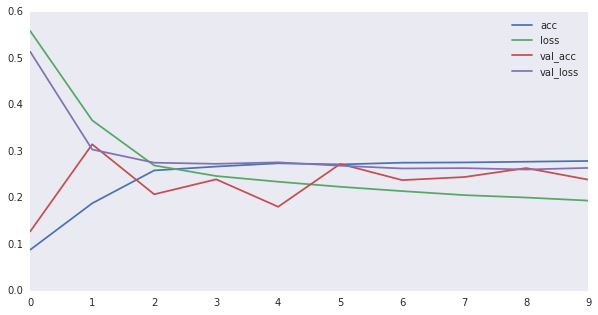

In [13]:
for label in sorted(hist.history):
    plt.plot(hist.history[label], label=label)
plt.legend();

In [14]:
def predict(model, X):
    Y_proba = model.predict(X, batch_size=batch_size, verbose=1).reshape(-1, target_count)
    Y_classes = (Y_proba >= 0.5).astype(np.int32)
    return Y_proba, Y_classes

Y_train_proba, Y_train_classes = predict(model, X_train)
Y_valid_proba, Y_valid_classes = predict(model, X_valid)

1271/1271 [==============================] - 4s     


In [15]:
Y_train_proba.shape

(375600, 12)

In [16]:
def evaluate_model(model, Y_true, Y_pred_classes, Y_pred_proba):
    print('accuracy:', accuracy_score(Y_true, Y_pred_classes))
    print('hamming score:', 1 - hamming_loss(Y_true, Y_pred_classes))
    print('AUC:', roc_auc_score(Y_true.flatten(), Y_pred_proba.flatten()))

print('-- training:')
evaluate_model(model, Y_train_flat, Y_train_classes, Y_train_proba)
print('-- validation:')
evaluate_model(model, Y_valid_flat, Y_valid_classes, Y_valid_proba)

-- training:
accuracy: 0.671387113951
hamming score: 0.9425108714944976
AUC: 0.976213832753
-- validation:
accuracy: 0.512234461054
hamming score: 0.8996643063204826
AUC: 0.935884223859


/home/bza/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


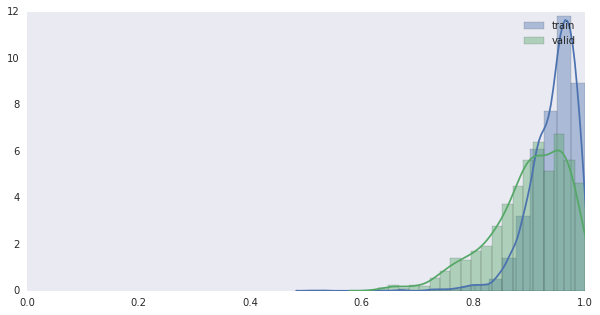

In [17]:
def hamming_score_dist_by_samples(Y_true, Y_pred_classes):
    Y_pred_classes_seq = Y_pred_classes.reshape(-1, max_seq_size, target_count)
    return np.array([1 - hamming_loss(Y_true[i], Y_pred_classes_seq[i]) for i in range(Y_true.shape[0])])

sns.distplot(hamming_score_dist_by_samples(Y_train, Y_train_classes), bins=20, label='train')
sns.distplot(hamming_score_dist_by_samples(Y_valid, Y_valid_classes), bins=20, label='valid')
plt.xlim(0, 1)
plt.legend();

In [18]:
# np.savetxt('yesterday_lstm_class.tsv', y_pred, delimiter='\t', fmt='%d')
# np.savetxt('yesterday_lstm_proba.tsv', y_pred_proba, delimiter='\t')

In [19]:
# np.savetxt('all_lstm_class.tsv', Y_train_pred, delimiter='\t', fmt='%d')
# np.savetxt('all_lstm_proba.tsv', Y_train_pred_proba, delimiter='\t')

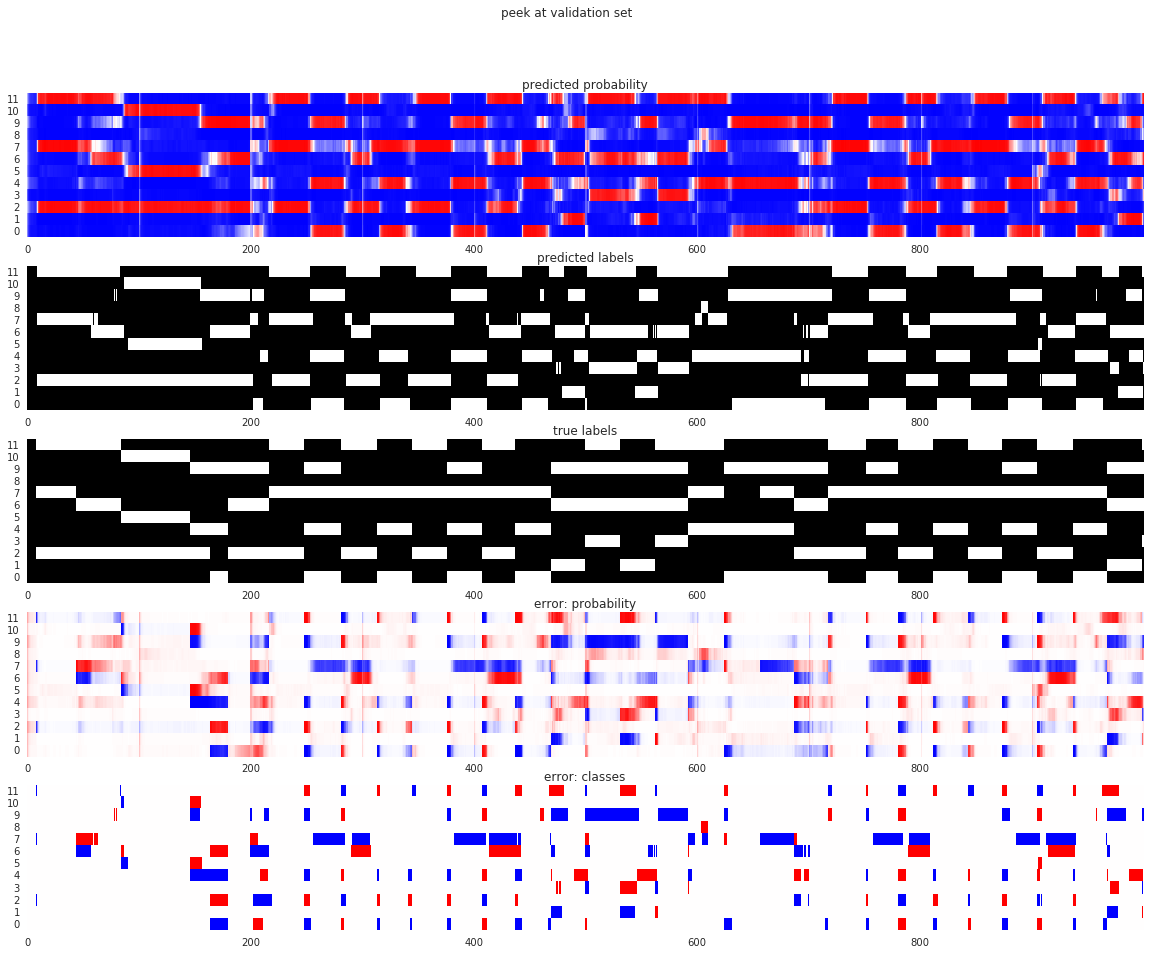

In [37]:
excerpt_start = 0
excerpt_len = 1000 #len(Y_valid.reshape(-1, 12))
excerpt_slice = slice(excerpt_start, excerpt_start + excerpt_len)
y_true = Y_valid_flat[excerpt_slice].T
y_pred_proba = Y_valid_proba.reshape(-1, 12)[excerpt_slice].T
y_pred_classes = Y_valid_classes.reshape(-1, 12)[excerpt_slice].T

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
f.suptitle('peek at validation set')
f.set_size_inches((20, 15))

ax1.imshow(y_pred_proba, vmin=0, vmax=1)
ax1.set_yticks(range(12))
ax1.set_title('predicted probability')

ax2.imshow(y_pred_classes, cmap='gray', vmin=0, vmax=1)
ax2.set_yticks(range(12))
ax2.set_title('predicted labels')

ax3.imshow(y_true, cmap='gray', vmin=0, vmax=1)
ax3.set_yticks(range(12))
ax3.set_title('true labels')

ax4.imshow(y_pred_proba - y_true, vmin=-1, vmax=1)
ax4.set_yticks(range(12))
ax4.set_title('error: probability')

ax5.imshow(y_pred_classes - y_true, vmin=-1, vmax=1)
ax5.set_yticks(range(12))
ax5.set_title('error: classes');

In [23]:
# with open('model_cnn_lstm_01.json', 'w') as file: file.write(model.to_json())

In [24]:
# model.save_weights('model_cnn_lstm_01_weights.h5')